In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

import wandb

In [2]:
dir_ = 'data' 
Classes = [
    folder for folder in os.listdir(dir_)
    if os.path.isdir(os.path.join(dir_, folder))
]
Classes

['Karacadag', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']

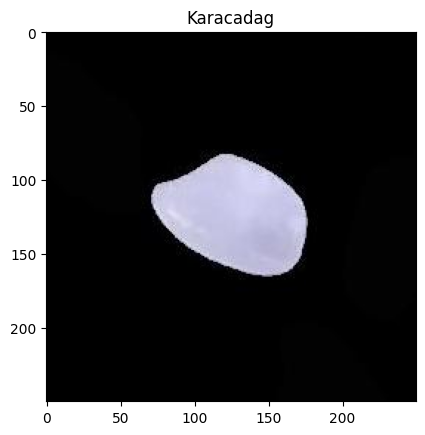

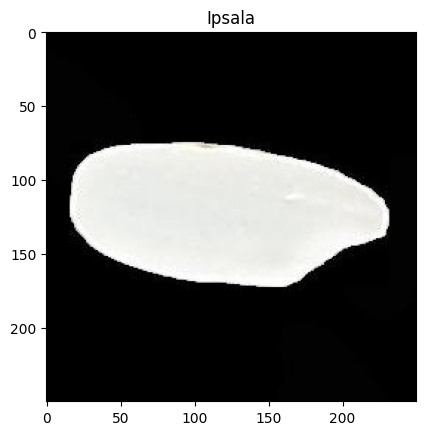

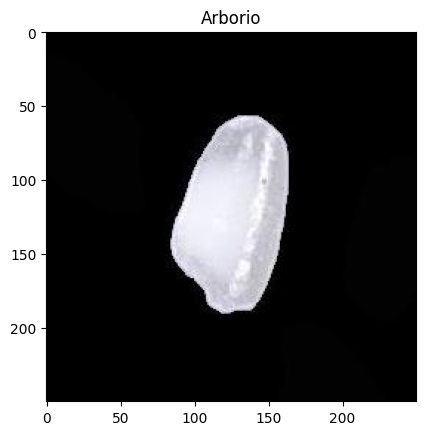

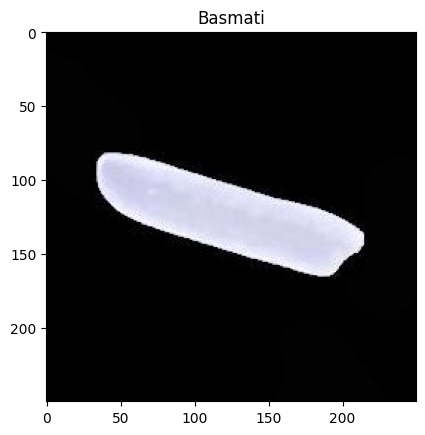

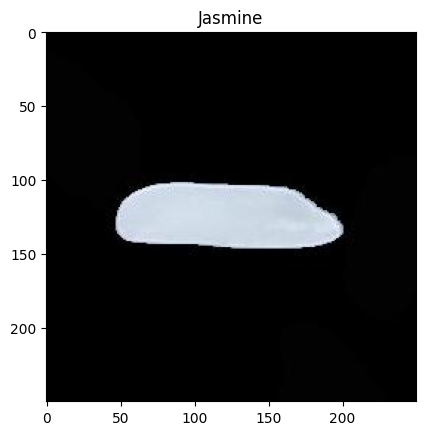

In [3]:
# plot for each class 5 images with the class name.

for Class in Classes:
    images = os.listdir(dir_ + '/' + Class)
    rand_images = random.sample(images, 1)
    for image in rand_images:
        img = mpimg.imread(dir_ + '/' + Class + '/' + image)
        plt.imshow(img)
        plt.title(Class)
        plt.show()


In [4]:
# plot the number of pictures in each class
num_images = []
for Class in Classes:
    images = os.listdir(dir_ + '/' + Class)
    num_images.append(len(images))
num_images


[15000, 15000, 15000, 15000, 15000]

In [5]:

all_sizes = {}

for Class in Classes:
    class_path = os.path.join(dir_, Class)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    sizes = set()
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            sizes.add(img.size)
    
    all_sizes[Class] = sizes  # Store unique sizes found in each class

all_sizes

{'Karacadag': {(250, 250)},
 'Ipsala': {(250, 250)},
 'Arborio': {(250, 250)},
 'Basmati': {(250, 250)},
 'Jasmine': {(250, 250)}}

In [6]:
output_dir = 'resized_data'
os.makedirs(output_dir, exist_ok=True)

new_size = (32, 32)

for Class in Classes:
    class_path = os.path.join(dir_, Class)
    output_class_path = os.path.join(output_dir, Class)
    os.makedirs(output_class_path, exist_ok=True)
    
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        output_image_path = os.path.join(output_class_path, image_file)
        
        with Image.open(image_path) as img:
            img.thumbnail(new_size)  # Keep aspect ratio
            img.save(output_image_path)  # Save to new folder

In [7]:
Classes_resized = os.listdir(output_dir)
Classes_resized

['Karacadag', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']

In [8]:
all_sizes = {}

for Class in Classes_resized:
    class_path = os.path.join(output_dir, Class)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    sizes = set()
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            sizes.add(img.size)
    
    all_sizes[Class] = sizes  # Store unique sizes found in each class

all_sizes

{'Karacadag': {(32, 32)},
 'Ipsala': {(32, 32)},
 'Arborio': {(32, 32)},
 'Basmati': {(32, 32)},
 'Jasmine': {(32, 32)}}

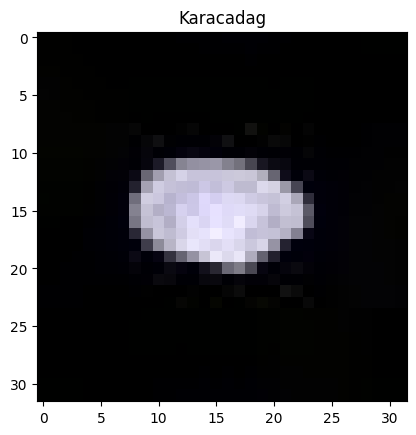

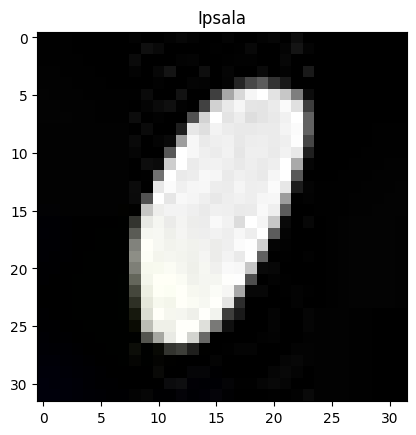

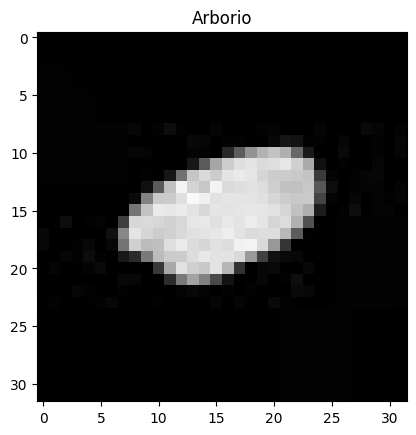

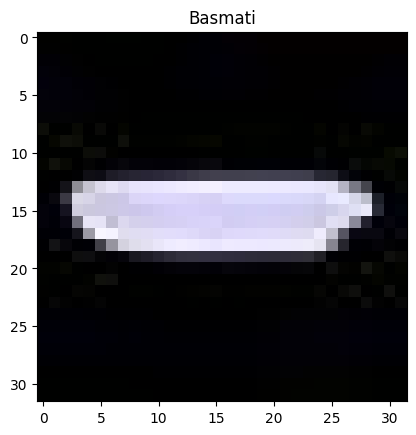

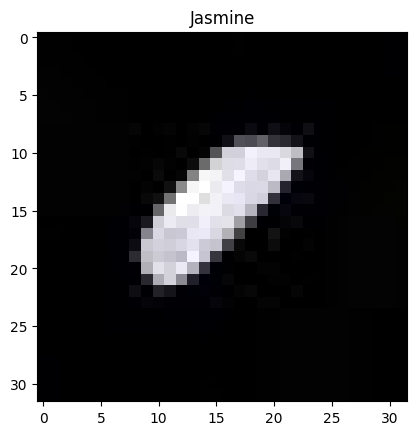

In [9]:
Classes = os.listdir('resized_data')

for Class in Classes:
    images = os.listdir(dir_ + '/' + Class)
    rand_images = random.sample(images, 1)
    for image in rand_images:
        img = mpimg.imread('resized_data' + '/' + Class + '/' + image)
        plt.imshow(img)
        plt.title(Class)
        plt.show()

---

# Schritt 3: Basismodell aufbauen, W&B-Integration & Evaluation

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [11]:
# Hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.001
project_name = "image-classification"
run_name = "baseline_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "BaselineCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oliver-pejic (oliver-pejic-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Dataset laden und splitten

In [12]:
DATA_DIR = "resized_data"

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

full_dataset = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes  = len(full_dataset.classes)
print(f"{len(full_dataset)} Bilder in {num_classes} Klassen:", full_dataset.classes)


75000 Bilder in 5 Klassen: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [13]:
# Split: 70% Train, 15% Val, 15% Test
train_len = int(0.7 * len(full_dataset))
val_len   = int(0.15 * len(full_dataset))
test_len  = len(full_dataset) - train_len - val_len

train_ds, val_ds, test_ds = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Train/Val/Test sizes: 52500/11250/11250


## Modell-Definition: BaselineCNN

In [14]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [15]:
model = BaselineCNN(num_classes).to(device)
wandb.watch(model, log="all", log_freq=10)
print(model)

BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


## Train-/Eval-Funktionen definieren

In [16]:
def train_one_epoch(model, loader, criterion, optimizer, epoch=None, log_to_wandb=True):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct  += (preds == labels).sum().item()
        total    += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and epoch is not None:
        wandb.log({"train_loss": epoch_loss,
                   "train_accuracy": epoch_acc,
                   "epoch": epoch})
        
    return epoch_loss, epoch_acc


def eval_one_epoch(model, loader, criterion, epoch=None, log_to_wandb=True):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct  += (preds == labels).sum().item()
            total    += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and epoch is not None:
        wandb.log({"val_loss": epoch_loss,
                   "val_accuracy": epoch_acc,
                   "epoch": epoch})
        
    return epoch_loss, epoch_acc


def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.title("Loss-Kurven")
    plt.xlabel("Epoche"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs,   label="Val Acc")
    plt.title("Accuracy-Kurven")
    plt.xlabel("Epoche"); plt.legend()
    plt.show()

## Overfitting-Test auf einem Einzel‐Sample

In [17]:
ov_model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ov_model.parameters(), lr=0.01, momentum=0.9)

img, lbl = train_ds[0]
img = img.unsqueeze(0).to(device)
lbl = torch.tensor([lbl], dtype=torch.long).to(device)

print(">>> Single-Sample Overfitting Test:")
for epoch in range(1, 21):
    ov_model.train()
    optimizer.zero_grad()
    out   = ov_model(img)
    loss  = criterion(out, lbl)
    loss.backward()
    optimizer.step()
    _, pred = out.max(1)
    acc      = 100*(pred==lbl).float().item()
    print(f"Epoche {epoch:02d}: Loss={loss.item():.4f}, Acc={acc:.1f}%")

>>> Single-Sample Overfitting Test:
Epoche 01: Loss=1.5859, Acc=0.0%
Epoche 02: Loss=1.3976, Acc=100.0%
Epoche 03: Loss=1.1132, Acc=100.0%
Epoche 04: Loss=0.7497, Acc=100.0%
Epoche 05: Loss=0.3257, Acc=100.0%
Epoche 06: Loss=0.0619, Acc=100.0%
Epoche 07: Loss=0.0052, Acc=100.0%
Epoche 08: Loss=0.0002, Acc=100.0%
Epoche 09: Loss=0.0000, Acc=100.0%
Epoche 10: Loss=0.0000, Acc=100.0%
Epoche 11: Loss=0.0000, Acc=100.0%
Epoche 12: Loss=0.0000, Acc=100.0%
Epoche 13: Loss=0.0000, Acc=100.0%
Epoche 14: Loss=0.0000, Acc=100.0%
Epoche 15: Loss=0.0000, Acc=100.0%
Epoche 16: Loss=0.0000, Acc=100.0%
Epoche 17: Loss=0.0000, Acc=100.0%
Epoche 18: Loss=0.0000, Acc=100.0%
Epoche 19: Loss=0.0000, Acc=100.0%
Epoche 20: Loss=0.0000, Acc=100.0%


## Training auf dem gesamten Trainingsset

>>> Training startet ...
Epoche 01: Train L=0.2918, A=89.8%;  Val L=0.0907, A=96.9%
Epoche 02: Train L=0.1030, A=96.5%;  Val L=0.0954, A=96.6%
Epoche 03: Train L=0.0814, A=97.1%;  Val L=0.0757, A=97.3%
Epoche 04: Train L=0.0644, A=97.8%;  Val L=0.0650, A=97.6%
Epoche 05: Train L=0.0501, A=98.4%;  Val L=0.0476, A=98.3%
Epoche 06: Train L=0.0407, A=98.7%;  Val L=0.0395, A=98.6%
Epoche 07: Train L=0.0361, A=98.8%;  Val L=0.0338, A=98.8%
Epoche 08: Train L=0.0337, A=98.9%;  Val L=0.0374, A=98.8%
Epoche 09: Train L=0.0311, A=99.0%;  Val L=0.0391, A=98.7%
Epoche 10: Train L=0.0287, A=99.1%;  Val L=0.0277, A=99.2%
Epoche 11: Train L=0.0263, A=99.2%;  Val L=0.0281, A=99.0%
Epoche 12: Train L=0.0247, A=99.2%;  Val L=0.0317, A=99.0%
Epoche 13: Train L=0.0237, A=99.2%;  Val L=0.0259, A=99.2%
Epoche 14: Train L=0.0227, A=99.3%;  Val L=0.0236, A=99.2%
Epoche 15: Train L=0.0217, A=99.3%;  Val L=0.0298, A=99.1%


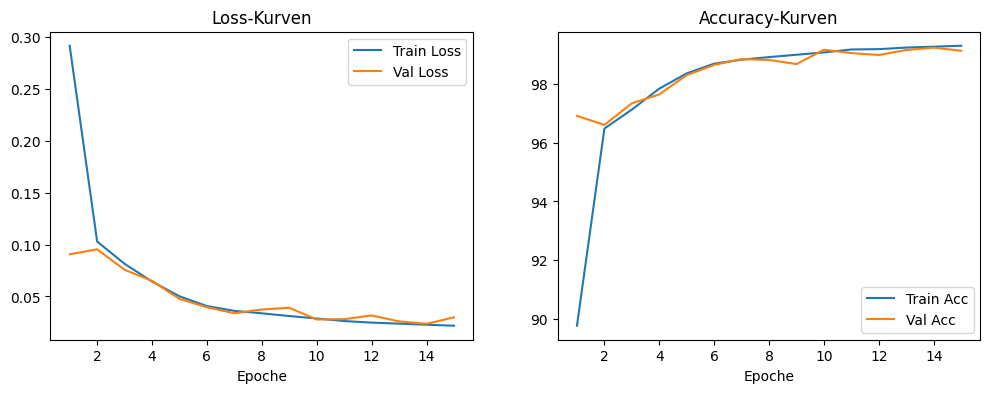

In [18]:
model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_losses, val_losses = [], []
train_accs, val_accs     = [], []

print(">>> Training startet ...")
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model, train_loader, criterion, optimizer, ep)
    vl, va = eval_one_epoch(model, val_loader,   criterion, ep)
    train_losses.append(tl);  train_accs.append(ta)
    val_losses.append(vl);    val_accs.append(va)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)


## Berechnung weiterer Metriken auf Test‐Set

In [19]:
def compute_metrics(model, loader):
    all_lbls, all_preds = [], []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            outs = model(imgs)
            _, preds = outs.max(1)
            all_lbls.extend(lbls.numpy())
            all_preds.extend(preds.cpu().numpy())
    p = precision_score(all_lbls, all_preds, average="macro")
    r = recall_score(all_lbls, all_preds, average="macro")
    f = f1_score(all_lbls, all_preds, average="macro")
    return p, r, f

precision, recall, f1 = compute_metrics(model, test_loader)
_, test_acc = eval_one_epoch(model, test_loader, nn.CrossEntropyLoss())
print(f"Test Accuracy: {test_acc:.1f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

wandb.log({
    "test_accuracy": test_acc,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1_score": f1
})

Test Accuracy: 99.0%
Precision: 0.990, Recall: 0.990, F1: 0.990


## 5-Fold Cross-Validation

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accs = []

print(">>> 5-Fold CV startet ...")
for fold, (tr_idx, va_idx) in enumerate(kf.split(full_dataset), start=1):
    tr_ds = Subset(full_dataset, tr_idx)
    va_ds = Subset(full_dataset, va_idx)
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False)

    m_cv = BaselineCNN(num_classes).to(device)
    opt = optim.SGD(m_cv.parameters(), lr=learning_rate, momentum=0.9)
    crit= nn.CrossEntropyLoss()

    for _ in range(5):
        _ , _ = train_one_epoch(m_cv, tr_ld, crit, opt, epoch=None, log_to_wandb=False)

    _ , acc = eval_one_epoch(m_cv, va_ld, crit, epoch=None, log_to_wandb=False)
    fold_accs.append(acc)
    print(f"Fold {fold}: Val Acc = {acc:.2f}%")

mean_acc = np.mean(fold_accs)
std_acc  = np.std(fold_accs)
print(f"\nCV-Resultate: Mean = {mean_acc:.2f}%, Std = {std_acc:.2f}%")


wandb.summary['cv_mean_accuracy'] = mean_acc
wandb.summary['cv_std_accuracy']  = std_acc

>>> 5-Fold CV startet ...
Fold 1: Val Acc = 98.77%
Fold 2: Val Acc = 98.75%
Fold 3: Val Acc = 99.08%
Fold 4: Val Acc = 97.42%
Fold 5: Val Acc = 98.65%

CV-Resultate: Mean = 98.53%, Std = 0.57%
